In [15]:
import pandas as pd
import numpy as np
import math
from alibi_detect.cd import TabularDrift
from alibi_detect.cd import ClassifierDrift
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [16]:
df = pd.read_csv(r"D:/GitHubLocal/NHL-Game-II/Period_1_Game_Stats_Final_ModelReady(April-10th-2022).csv")

In [17]:
df.dtypes

won                        int64
Shots                    float64
Shots_Against            float64
Goals                    float64
Goals_Against            float64
Takeaways                float64
Takeaways_Against        float64
Hits                     float64
Hits_Against             float64
Blocked Shots            float64
Blocked Shots Against    float64
Giveaways                float64
Giveaways_Against        float64
Missed Shots             float64
Missed Shots_Against     float64
Penalities               float64
Penalities_Against       float64
#Won Faceoffs            float64
#Lost Faceoffs           float64
HoA_away                   int64
HoA_home                   int64
dtype: object

In [18]:
df.head()

,won,Shots,Shots_Against,Goals,Goals_Against,Takeaways,Takeaways_Against,Hits,Hits_Against,Blocked Shots,...,Giveaways,Giveaways_Against,Missed Shots,Missed Shots_Against,Penalities,Penalities_Against,#Won Faceoffs,#Lost Faceoffs,HoA_away,HoA_home
0,0,8.0,8.0,0.0,3.0,1.0,3.0,14.0,5.0,3.0,...,6.0,7.0,4.0,0.0,1.0,1.0,10.0,12.0,1,0
1,1,8.0,8.0,3.0,0.0,3.0,1.0,5.0,14.0,3.0,...,7.0,6.0,0.0,4.0,1.0,1.0,12.0,10.0,0,1
2,1,11.0,12.0,0.0,1.0,0.0,2.0,4.0,4.0,6.0,...,2.0,0.0,6.0,3.0,1.0,3.0,11.0,9.0,1,0
3,0,12.0,11.0,1.0,0.0,2.0,0.0,4.0,4.0,8.0,...,0.0,2.0,3.0,6.0,3.0,1.0,9.0,11.0,0,1
4,1,9.0,8.0,0.0,1.0,3.0,2.0,4.0,5.0,7.0,...,7.0,5.0,3.0,8.0,2.0,1.0,7.0,11.0,1,0


In [59]:
#Get features
X_features = df.drop("won",axis=1)
#Get the feature names
feature_names = X_features.columns

In [60]:
def split_ref_new(df, last_n):
    """
    Splits the main dataframe into a reference and new dataframe and np.array for drift detection
    """
    X_ref = np.array(df.iloc[:-last_n,:])
    df_ref = df.iloc[:-last_n,:]
    X_new = np.array(df.iloc[-last_n:,:])
    df_new = df.iloc[-last_n:,:]
    
    return X_ref, df_ref, X_new, df_new

In [61]:
X_ref, df_ref, X_new, df_new = split_ref_new(X_features, 50)

In [62]:
#TabularDrift: K-S tests for num features, Chi-squared for categorical
cd = TabularDrift(p_val=0.05, x_ref = X_ref)

In [63]:
#Predict general drift
preds = cd.predict(X_new, return_p_val=True, return_distance = True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [64]:
#Predict the drift for each feature
fpreds = cd.predict(X_new, drift_type="feature", return_p_val=True, return_distance=True)

In [65]:
#Get drift per feature
feature_drift = []
for f in range(cd.n_features):
    stat = 'K-S'
    fname = feature_names[f]
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
    feature_drift.append(labels[is_drift])

Shots -- Drift? No! -- K-S 0.105 -- p-value 0.597
Shots_Against -- Drift? No! -- K-S 0.071 -- p-value 0.945
Goals -- Drift? No! -- K-S 0.120 -- p-value 0.438
Goals_Against -- Drift? No! -- K-S 0.060 -- p-value 0.990
Takeaways -- Drift? No! -- K-S 0.125 -- p-value 0.380
Takeaways_Against -- Drift? No! -- K-S 0.085 -- p-value 0.829
Hits -- Drift? Yes! -- K-S 0.191 -- p-value 0.045
Hits_Against -- Drift? Yes! -- K-S 0.253 -- p-value 0.003
Blocked Shots -- Drift? No! -- K-S 0.074 -- p-value 0.929
Blocked Shots Against -- Drift? Yes! -- K-S 0.194 -- p-value 0.040
Giveaways -- Drift? No! -- K-S 0.074 -- p-value 0.929
Giveaways_Against -- Drift? No! -- K-S 0.080 -- p-value 0.877
Missed Shots -- Drift? No! -- K-S 0.099 -- p-value 0.678
Missed Shots_Against -- Drift? No! -- K-S 0.123 -- p-value 0.400
Penalities -- Drift? No! -- K-S 0.065 -- p-value 0.976
Penalities_Against -- Drift? No! -- K-S 0.105 -- p-value 0.608
#Won Faceoffs -- Drift? No! -- K-S 0.144 -- p-value 0.225
#Lost Faceoffs -- Dri

In [72]:
def plot_features(new_data, ref_data):
    
    n_cols = 4
    n_rows = math.ceil((len(ref_data.columns)/4))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    axs = axs.ravel()
    binwidth = 1
    for i in range(len(ref_data.columns)):
        bins = int((ref_data.iloc[:,i].max() - ref_data.iloc[:,i].min())/binwidth)
        ref_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="blue", bw_method='silverman')
        new_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="red", bw_method='silverman')
        
        axs[i].set_title(f'Distribution: {ref_data.columns[i]} - Drift: {feature_drift[i]}')
    
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

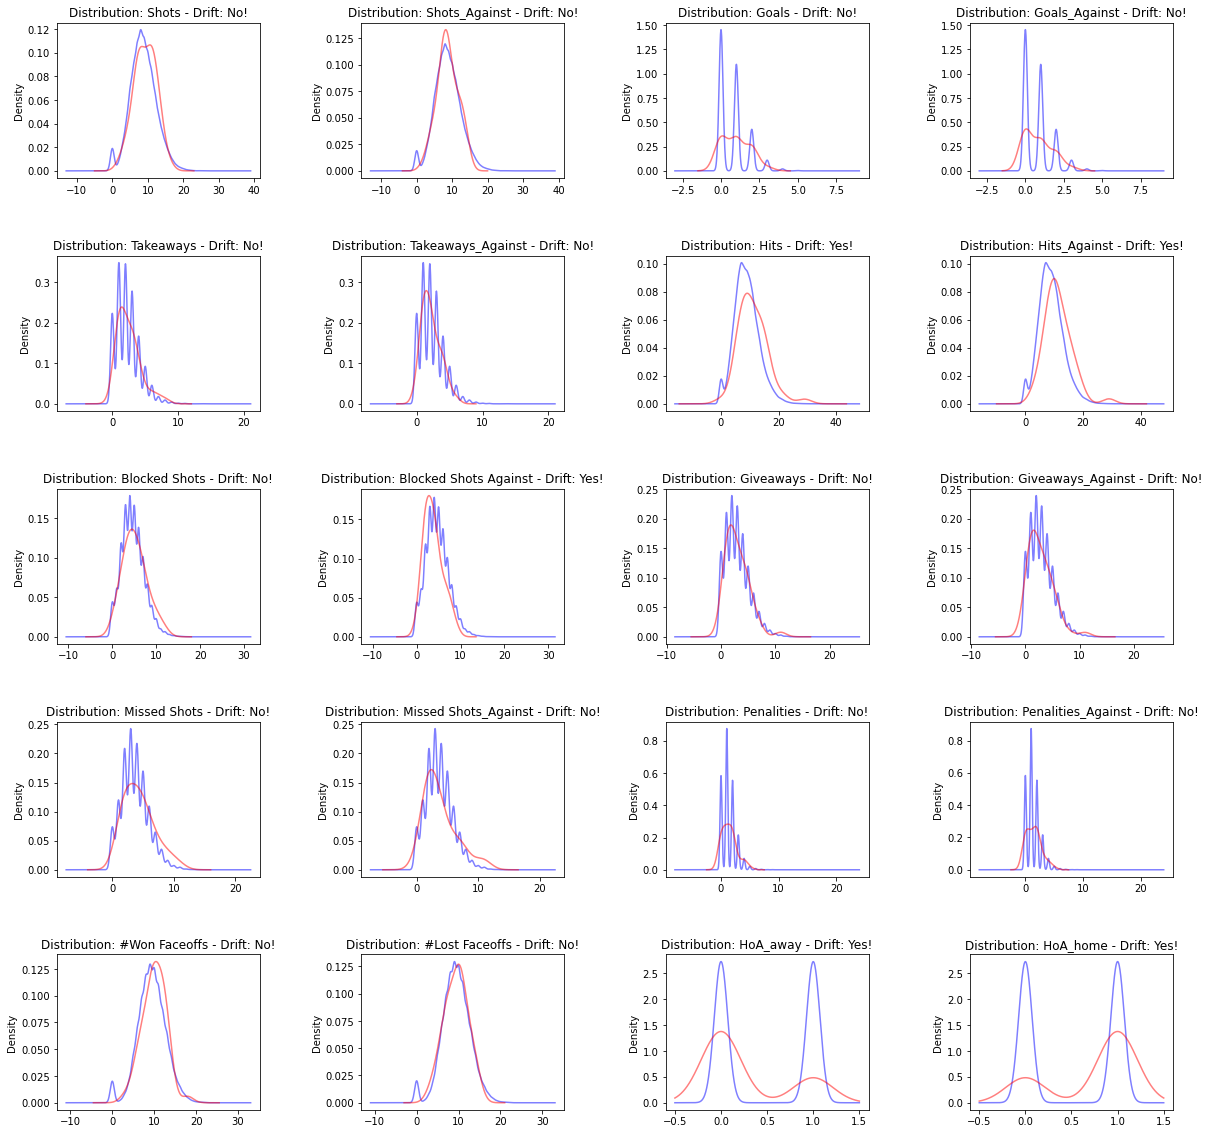

In [73]:
plot_features(df_new, df_ref)